## Anura3D Workshop Small Strain Oedometer

The purpose of this notebook is to run Anura3D for a small strain oedometer problem and plot the results versus the analytical solution

## 1) Set up the notebook for running in google colab

The next couple of cells import the libraries necessary to run the oedometer model and plot the data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

In [32]:
if sys.platform.startswith('win'):
    # Run code specific to Windows environment
    print("Running on Windows")
    ON_WINDOWS = True 
    
elif sys.platform.startswith('linux'):
    # Run code specific to Linux environment
    print("Running on Linux")
    
    ON_WINDOWS = False
else:
    # Handle other platforms if needed
    print("Running on a different platform")
    # Your code here
    ON_WINDOWS = None

Running on Windows


In [33]:
# Check if there's a google colab environment
try:
  import google.colab
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [34]:

# Commands to only run when in google colab

if IN_COLAB:
  # Change the directory to content
  %cd /content
  
  # Clone the repo
  print("Try to clone the repo")
  !git clone https://github.com/Anura3D/Anura3D_Workshop.git

  # List the files
  !ls

  print("\nTry updating the repo if there are new changes")
  # Change the directory to the Git repo
  %cd /content/Anura3D_Workshop

  # Pull changes if there are new changes
  !git pull

  # Change the repo back to contact
  !cd /content 

  # Update the executable permissions
  !chmod +rx /content/Anura3D_Workshop/Oedometer_tri_MP_v1_1.A3D/Anura3D.out

  # Cd into the repo
  %cd /content/Anura3D_Workshop
else:
  print("Not in Colab")

Not in Colab


### Import the functions required for plotting the model

In [35]:
# Import the model class that serves as the object that let's you run models
from lib.data_classes.Model import model
from lib.benchmark_info.run_benchmarks_info import benchmark_info_dict

# import isochrone function
from lib.general_functions.terzaghi_pressure_solution import terzaghi_pressure_solution

# import the PAR file processing function 
from lib.general_functions.read_mpm_data import process_parfiles

# import function to plot the settlement solution
from lib.general_functions.terzaghi_settlement_solution import terzaghi_settlement_solution

# import the functions to plot the numerical solutions
from lib.general_functions.read_mpm_data import plot_analytical_numerical_solutions



### Set the executable path
The windows option is in case you want to run it locally on your computer.

In [36]:
# Excetuable directory
if ON_WINDOWS:
    exe_path = r"./Oedometer_tri_MP_v1_1.A3D/Anura3D_2023.exe"
else:
    exe_path = r"./Oedometer_tri_MP_v1_1.A3D/Anura3D.out"

# Select the tutorial model (Can be a relative path)
model_name = "Oedometer_tri_MP_v1_1"

# Get the current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

model_folder = os.path.join(os.getcwd(), r"Oedometer_tri_MP_v1_1.A3D")
print(f"Model folder dir: {model_folder}")

Current working directory: c:\Geotech_Research\Anura3D_Workshop
Model folder dir: c:\Geotech_Research\Anura3D_Workshop\Oedometer_tri_MP_v1_1.A3D


## 2) Bookeeping and running the model

In [37]:
anura3D_model = model(exe_path, model_folder, model_name, benchmark_name = "small_strain_oedometer", benchmark=True)

### Printing some information about the model and delete possible files from previous runs

In [38]:
print(anura3D_model)

# Delete the files in the .A3D folder
# anura3D_model.delete_folder_files()

Model Name: Oedometer_tri_MP_v1_1 
Model Path: c:\Geotech_Research\Anura3D_Workshop\Oedometer_tri_MP_v1_1.A3D\Oedometer_tri_MP_v1_1 
Executable Path: ./Oedometer_tri_MP_v1_1.A3D/Anura3D_2023.exe


### Run the oedometer model

In [39]:
# Run the model
anura3D_model.run_benchmark()

Model Complete!


### 3) Download the files locally if you want to make modifications locally

In [40]:
# Change download_files to True if you want to download the files you your personal computerr, only necessary if running in colab
download_files = False

# Download te files if you want
if IN_COLAB and download_files:
    # Download the results filer
    !zip -r /content/oedometer_data.zip /content/Anura3D_Workshop/Oedometer_tri_MP_v1_1.A3D

    #from google.colab import files
    from google.colab import files
    files.download("/content/oedometer_data.zip")

## 4) Calculate the analytical solution using Terzaghi's small strain solution

0.010026368263473053


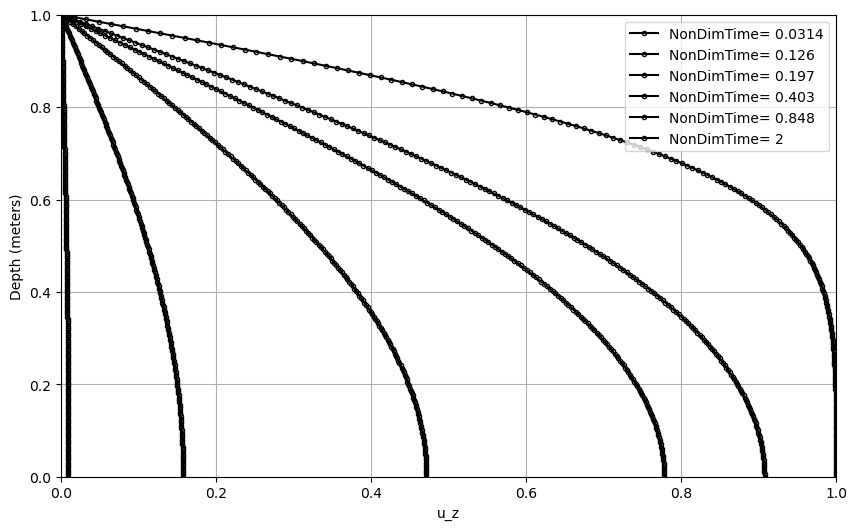

In [41]:
## ANALYTICAL SOLUTION CALCULATIONS
## INPUTS

# sampling
DataPoints = 200 #arbitrary integer for discretizing depth

# geometry 
LayerDepth = 1 # [m]

# material parameters
IntrinsicPermeability = 1.0241e-9 #Value from the tutorial manual #m^2 #5e-5
Porosity = 0.4 # Value from the tutorial manual #no units #0.3
Viscosity = 1.002e-3 # [Pa-s] (or kg/sm)
YoungsModulus = 1000e3 # Value from the tutorial manual #Pa
PoissonRatio = 0.3 
LiquidDensity = 1000 # [kg/m3]
GravitationalAcceleration = 9.81 # [m/s2]

# dimensional or nondimensional time input 
DimensionalTimeInput = False
target_nondimtimes = (0.0314, 0.126, 0.197, 0.403, 0.848, 2)

# Call the function and capture the results
u_z, DimensionalTime, NondimensionalTime, DepthArray = terzaghi_pressure_solution(
    DataPoints,
    LayerDepth,
    IntrinsicPermeability,
    Porosity,
    Viscosity,
    YoungsModulus,
    PoissonRatio,
    LiquidDensity,
    DimensionalTimeInput,
    EndTime=0.1, # if DimensionalTimeInput=True, you need to input the endtime for datarange
    target_times=target_nondimtimes, #0.2, 0.3, 0.4, 0.5, 1),
    plot_results=True  # Optional plotting control
)

In [42]:

# Define a list of directories
directories = [anura3D_model.model_folder]

# Call the function with the list of directories
par_dataframes_by_directory = process_parfiles(directories)


Processing 'c:\Geotech_Research\Anura3D_Workshop\Oedometer_tri_MP_v1_1.A3D'
base name Oedometer_tri_MP_v1_1.A3D
file name: Oedometer_tri_MP_v1_1


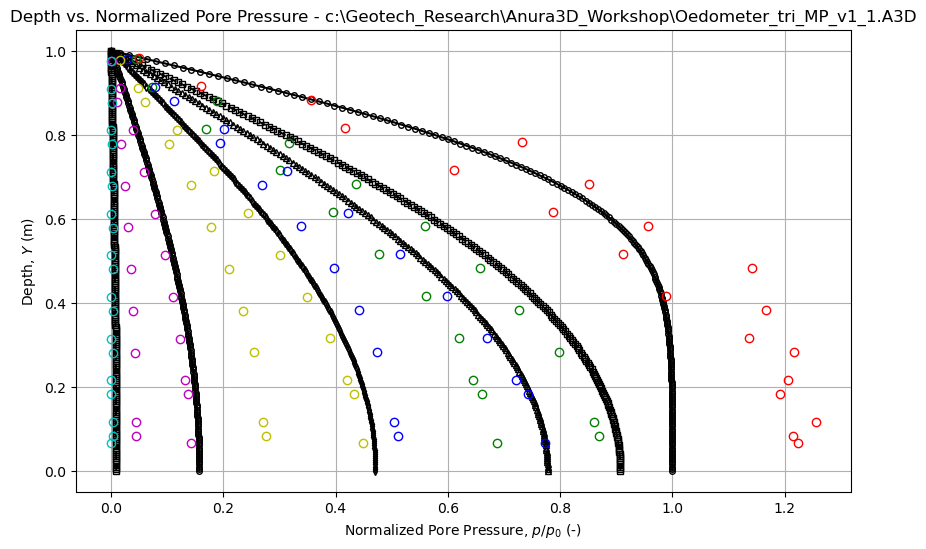

In [43]:

TractionLoad = -10 #kPa

# Call the function with the appropriate arguments
plot_analytical_numerical_solutions(
    par_dataframes_by_directory,
    u_z,
    DepthArray,
    NondimensionalTime,
    TractionLoad
)

In [44]:
## GENERATE PRIMARY CONSOLIDATION SETTLEMENT CALCULATION 

TractionLoad = -10e3 # N used in the numerical solution
NondimensionalTime = np.linspace(0,5,DataPoints) #generating a series of depths z

UU = terzaghi_settlement_solution(LayerDepth, TractionLoad, NondimensionalTime, YoungsModulus, PoissonRatio)


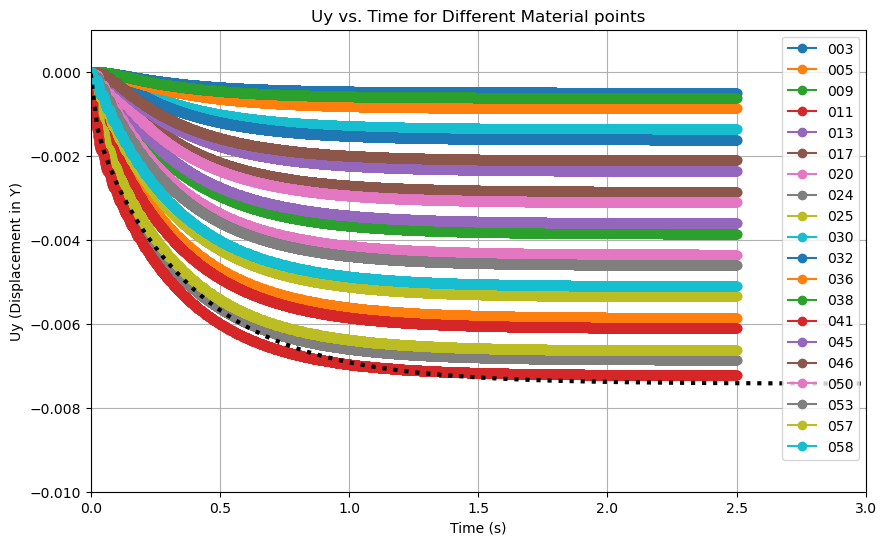

In [45]:
## PLOT NUMERICAL SOLUTION AGAINST THE ANALYTICAL SOLUTION 
# Loop through each key and DataFrame in par_dataframes_by_directory
for dir_key, dataframes in par_dataframes_by_directory.items():  # Loop through each directory
    # Initialize a plot
    plt.figure(figsize=(10, 6))  # Set the plot size
    for file_key, df in dataframes.items():  # Loop through each DataFrame
        if "Uy" in df.columns and "Time" in df.columns:  # Ensure the variables exist
            # Extract `Uy` and `Time`
            uy_values = df["Uy"]  # Displacement along Y-axis
            time_values = df["Time"]  # Corresponding time

            # Plot `Uy` vs. `Time` for each DataFrame
            plt.plot(time_values, uy_values, 'o-', label=f"{file_key[-3:]}")  # Line with markers
            plt.legend()


    # Customize the plot
    plt.xlabel("Time (s)")  # X-axis label
    plt.ylabel("Uy (Displacement in Y)")  # Y-axis label
    plt.title("Uy vs. Time for Different Material points")  # Plot title
    plt.grid(True)  # Add gridlines
    #plt.legend()  # Display the legend to differentiate plots by directory and file

    plt.plot(NondimensionalTime, UU, linestyle=':', color='black', linewidth=3)
    plt.xlim(0, 3)
    plt.ylim(-0.01, 0.001)
    # Display the plot
    plt.show()  # Show the plot